# გულის დაავადების წინასწარმეტყველება, წრფივი რეგრესიის გამოყენებით

ჩვენ ვიყენებთ  **Logistic Regression** , **scikit-learn** დან რომ შევაფასოთ **გულის დაავადება**.

ჩვენი მიზანია გვქონდე რაც შეიძ₾ება დიდი **F1** score.

Our steps:
1. მონაცემების დამუშავება
2. მონაცემების გაყოფა
3. წრფივი რეგრესიიის შექმნა
4. პარამეტრების შერჩევა ლოგისტიკური რეგრესიისთვის
5. რეგრესიის ალგოტითმის გაშვება და მონაცემების წინასწარმეტყველება
6. საუკეთესო მოდელი

## შესავალი

ჯანმრთელობის მსოფლიო ორგანიზაციამ შეაფასებით 12 მილიონი ადამიანი იღუპება მსოფლიოში, ყოველწლიურად გულის დაავადებების გამო. გარდაცვალების ნახევარი შეერთებულ შტატებში და განვითარებულ სხვა ქვეყნებში განპირობებულია კარდიოვასკულური დაავადებებით. გულ-სისხლძარღვთა დაავადებების ადრეულ პროგნოზს შეუძლია დაეხმაროს მაღალი რისკის მქონე პაციენტებში ცხოვრების წესის ცვლილებებზე გადაწყვეტილების მიღებაში და, თავის მხრივ, ამცირებს გართულებებს. ეს კვლევა მიზნად ისახავს გულის დაავადებების ყველაზე აქტუალური / რისკ ფაქტორების აღნიშვნას, აგრეთვე ზოგადი რისკის წინასწარ განსაზღვრას ლოგისტიკური რეგრესიის გამოყენებით.

# Imports

In [221]:
# for vector computations and data processing
import pandas as pd
import numpy as np 

# for statistical work
import statsmodels.api as sm
import scipy.stats as st

# for plotting
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
import seaborn as sn

# for using ML models and their scoring
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, make_scorer, precision_score, recall_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# დამხმარე ფუნქცია

In [222]:
def hist_plot(dataframe, features, rows, cols):
    fig = plt.figure(figsize=(20, 20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        dataframe[feature].hist(bins=20, ax=ax, facecolor='midnightblue')
        ax.set_title(feature+" Distribution", color='DarkRed')

    fig.tight_layout()
    plt.show()

In [223]:
def pie_plot(series, figsize=(7, 7)):
    ax_ = plt.figure(figsize=figsize).add_subplot()
    ax_.pie(series.value_counts(), labels=series.value_counts().index)

In [224]:
def corr_plot(dataframe, figsize=(10, 10)):
    axes_ = plt.figure(figsize=figsize).add_subplot()
    corr = dataframe.corr()
    ax = sn.heatmap(
        corr,
        vmin=-1, vmax=1, center=0,
        cmap=sn.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

In [225]:
def barh_plot(series, figsize=(10, 10)):
    ax_ = plt.figure(figsize=figsize).add_subplot()
    ax_.barh(series.index, series.values)

In [226]:
def plot_roc_auc_curve(y_test, y_pred, clf, X_test):
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    plt.figure(figsize=[10,7])
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [227]:
def precision_recall_f1_curve_plot(y_test, y_pred_proba, figsize=(10, 10)):
    ax_ = plt.figure(figsize=figsize).add_subplot()
    df_ = pd.DataFrame(precision_recall_curve(y_test, y_pred_proba), index=['Precision', 'Recall', 'Threshold']).T
    df_['F1'] = 2*df_['Precision']*df_['Recall']/(df_['Precision'] + df_['Recall'])
    df_.plot(ax=ax_)
    optimal_threshold = df_[df_['F1'] == df_['F1'].max()]['Threshold'].iloc[0]
    return df_, optimal_threshold

In [228]:
def confusion_matrix_plot(y_test, y_pred, labels=(1, 0), figsize=(8, 5)):
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    conf_matrix = pd.DataFrame(
        data=cm, columns=['Predicted:1', 'Predicted:0'], index=['Actual:1', 'Actual:0'])
    plt.figure(figsize=figsize)
    sn.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
    return cm

In [229]:
def show_scores(confusion_matrix):
    # get "default" confusion matrix values
    TP = confusion_matrix[0, 0]
    TN = confusion_matrix[1, 1]
    FP = confusion_matrix[1, 0]
    FN = confusion_matrix[0, 1]

    # calculate scores
    accuracy = (TP+TN)/float(TP+TN+FP+FN)
    precision = TP/float(TP+FP)
    recall = TP/float(TP+FN)
    f1 = 2*precision*recall/float(precision+recall)

    # print scores
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')
    
    return accuracy, precision, recall, f1

In [230]:
def binarize(probas, threshold):
    preds = (probas >= threshold).astype(np.int64)
    return preds

# მონაცემის მომზადება

## წყარო
მონაცემთა ბაზა საჯაროდ ხელმისაწვდომია Kaggle ვებსაიტზე და ეყდნობა გულ-სისხლძარღვთა გამოკვლევის შედეგად,რომელიც ჩატარდა მასაჩუსეტსის ქალაქ ფრიინგჰემში. კლასიფიკაციის მიზანია იმის დადგენა, აქვს თუ არა პაციენტს 10 წლიანი რისკი გულის კორონარული დაავადებების (CHD) მომავალი დაავადების შესახებ (CHD). მოცემულია პაციენტების ინფორმაცია,რომლეიც მოიცავს 4000-ზე მეტ ჩანაწერს და 15 ატრიბუტს.

## მონაცემების წაკითხვა

In [234]:
heart_df=pd.read_csv("data/workshop_1/framingham.csv")

In [235]:
heart_df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## ცვლადები:

Each attribute is a potential risk factor. There are both **demographic**, **behavioural** and **medical** risk factors.

 - **Demographic:**
    - sex: male or female;(Nominal)

    -  age: age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)


 - **Behavioural**

    -  currentSmoker: whether or not the patient is a current smoker (Nominal)

    -  cigsPerDay: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarretts, even half a cigarette.)

 - **Medical( history):**

    -  BPMeds: whether or not the patient was on blood pressure medication (Nominal)

    -  prevalentStroke: whether or not the patient had previously had a stroke (Nominal)

    -  prevalentHyp: whether or not the patient was hypertensive (Nominal)

    -  diabetes: whether or not the patient had diabetes (Nominal)

 - **Medical(current):** 

    -  totChol: total cholesterol level (Continuous)

    -  sysBP: systolic blood pressure (Continuous)

    -  diaBP: diastolic blood pressure (Continuous)

    -  BMI: Body Mass Index (Continuous)

    -  heartRate: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)

    -  glucose: glucose level (Continuous)


 - **Predict variable (desired target):**

    -  10 year risk of coronary heart disease CHD (binary: “1”, means “Yes”, “0” means “No”)


## მონაცემების დანაკლისის სტატისტიკა

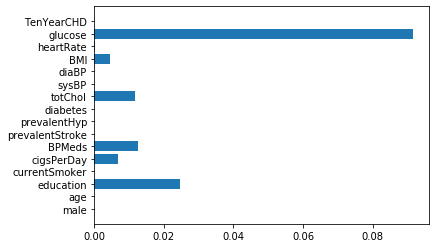

In [236]:
plt.barh(heart_df.isnull().sum().index, heart_df.isnull().sum()/heart_df.shape[0]);

In [237]:
na_percentage = ((heart_df.shape[0] - heart_df.dropna().shape[0])/heart_df.shape[0])*100.0

In [238]:
print(f'we will remove missing values since we have {np.around(na_percentage, decimals=2)} percent of rows in total with empty values')

we will remove missing values since we have 13.73 percent of rows in total with empty values


In [239]:
# remove all rows with na values

heart_df.dropna(inplace=True)

# წინასწარი ანალიტიკა

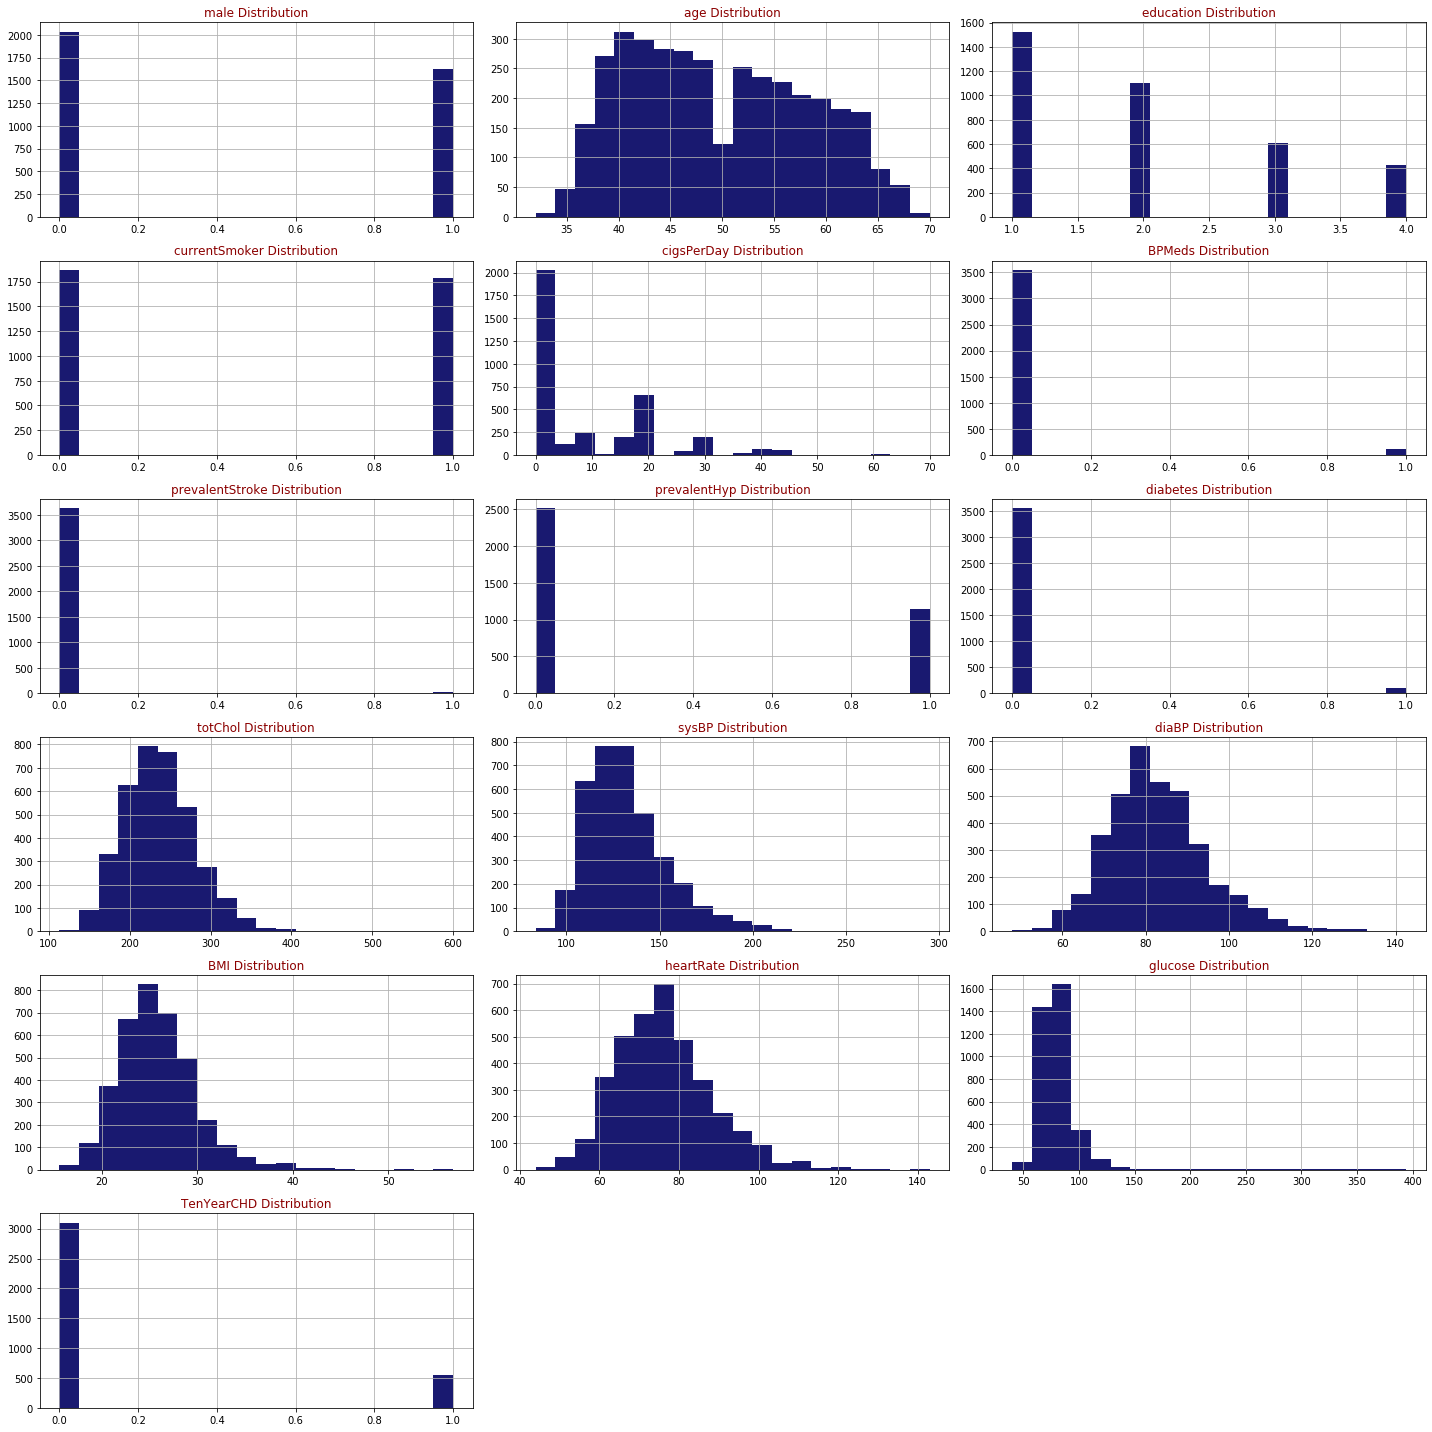

In [240]:
hist_plot(dataframe=heart_df, features=heart_df.columns, rows=6, cols=3)

## მონაცემების სტატისტიკა

In [241]:
heart_df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000,3658.000000
mean,0.443685,49.551941,1.980317,0.489065,9.025424,0.030344,0.005741,0.311646,0.027064,236.847731,132.370558,82.917031,25.782802,75.730727,81.852925,0.152269
std,0.496886,8.562029,1.022656,0.499949,11.921590,0.171557,0.075561,0.463229,0.162292,44.097681,22.086866,11.974258,4.065601,11.981525,23.904164,0.359331
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.080000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,143.875000,90.000000,28.037500,82.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,600.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


## წყვილებად გრაფიკის აგება

In [ ]:
pd.plotting.scatter_matrix(heart_df, figsize=(20, 20));

##კორელაცია 

In [ ]:
corr_plot(heart_df, figsize=(20,20))

## Show Features Correlations with Target sorted with absolute value

In [ ]:
barh_plot(heart_df.corr()['TenYearCHD'].abs().sort_values(ascending=True))

In [ ]:
heart_df.corr()['TenYearCHD'].abs().sort_values(ascending=True)

## სამიზანე მონაცემემის ანალიტიკური შეფასება

In [ ]:
pie_plot(heart_df.TenYearCHD)

In [ ]:
print(f'There are {(heart_df.TenYearCHD == 0).sum()} patents with no heart disease and {(heart_df.TenYearCHD == 1).sum()} patients with risk of heart disease.')

## მაღალი კორელაციის ველების არჩევა

- glucose            0.121990
- diaBP              0.150124
- prevalentHyp       0.181387
- sysBP              0.222821
- age                0.233983
- TenYearCHD         1.000000

In [ ]:
 heart_df = heart_df[['glucose', 'diaBP', 'prevalentHyp', 'sysBP', 'age', 'TenYearCHD']]

# მონაცემების გაყოფა

In [ ]:
# Copy all features except target to X and target to Y
X = heart_df[['glucose', 'diaBP', 'prevalentHyp', 'sysBP', 'age' ]]
y = heart_df[['TenYearCHD']]

In [ ]:
X.shape, y.shape

Let's take 20% of samples for test

In [ ]:
y.head()

In [ ]:
# Split data into train and test set with 20% of test samples, stratify with target and random state 5
x_train, x_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=5)

# ლოგისტიკური რეგრესია


ლოგისტიკური რეგრესია არის რეგრესიული ანალიზის სახეობა სტატისტიკაში. ლოგისტიკური რეგრესიის დროს დამოკიდებული ცვლადი ყოველთვის ბინარულია. ლოგისტიკური რეგრესი ძირითადად გამოიყენება პროგნოზირებისთვის და ასევე წარმატების ალბათობის გამოთვლისას.

In [ ]:
# create logistic regression model
model = LogisticRegression()

###  Logistic Regression-ის ჰიპერპარამეტრები

Subset of parameters for tuning

- penalty : str, ‘l1’, ‘l2’, ‘elasticnet’ or ‘none’, optional (default=’l2’)
- C : float, optional (default=1.0)
- class_weight : dict or ‘balanced’, optional (default=None)
- solver : str, {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, optional (default=’liblinear’).
- max_iter : int, optional (default=100)

## RandomizedSearchCV

### შევამოწმოთ Random Distribution for Regularization პარამეტრები

In [ ]:
pd.Series(st.expon.rvs(size=1000)).hist(bins=20)

###  Random Parameters- ის შექმნა

In [ ]:
# create random parameters for cross validated random search
parameters = {
    'penalty': ['l1', 'l2'],
    'C': st.expon.rvs(size=200),
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'saga'],
    'max_iter': np.random.rand(100)*200
}


### Random  Object- შექმნა

In [ ]:
RANDOM_STATE = 42
CV = 10
RANDOM_ITERS = 50
# Create scoring parameters for AUC, Recall and Precision
SCORING = {
    "AUC": "roc_auc",
    "Recall": make_scorer(recall_score),
    "Precision":make_scorer(precision_score) 
}

-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) object using:
- estimator: our initialized logistic regression model
- random_state: which we defined
- param_distributions: defined search parameters
- cv: cross validation splits number which we defined above
- scoring: prepared scoring parameters
- refit: "AUC" to get model with best AUC score
- verbose: True if want to see logs of model training
- n_jobs: -1 if want to train on all CPU resource (does faster)
- n_iter: number of iterations for choosing random models

In [ ]:
# crete random search cross validation object here with paramaters defined above
random_model = RandomizedSearchCV(estimator=model,
                                  random_state=RANDOM_STATE,
                                  param_distributions=parameters,
                                  cv=CV,
                                  scoring=SCORING,
                                  refit='AUC',
                                  verbose=True,
                                  n_jobs=-1,
                                  n_iter=RANDOM_ITERS)

### საუკეთსო მოდელის მიღება

In [ ]:
# fit model on training data
best_random_model = random_model.fit(x_train, y_train)

### Show Cross Validation Results on all Searched Parameter Models

In [ ]:
pd.DataFrame(best_random_model.cv_results_).hist(figsize=(20, 20));

### საუკეთესო მოდელის პარამეტრები

In [ ]:
# show best model parameters
best_random_model.best_params_


In [ ]:
# show best models best sc
best_random_model.best_score_


## მოდელის შედეგები

###მოდელის ნაწინასწარმეტყველები  მონაცემები

In [ ]:
# do prediction on test data using best model
y_pred = best_random_model.predict(x_test)

###  Confusion  Matrix ჩვენება - სად როგორ იმუშავა პროგრამამ

In [ ]:
cm = confusion_matrix_plot(y_test, y_pred)

### მოდელის სტატისტიკა

In [ ]:
show_scores(cm);

### ROC-AUC Score

In [ ]:
plot_roc_auc_curve(y_test, y_pred, best_random_model, x_test)